In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load your image
image_path = './duck.png'
image = cv2.imread(image_path)

# Convert to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)[2000:3000, 1500:2500]

# Get the image dimensions
(height, width) = gray_image.shape[:2]

# Calculate the center of the image
center = (width // 2, height // 2)

# Calculate the rotation matrix
rotation_matrix = cv2.getRotationMatrix2D(center, 45, 1.0)

# Perform the rotation
rotated_image = cv2.warpAffine(gray_image, rotation_matrix, (width, height))


In [2]:
# Find the position of the brightest point
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(gray_image)

# max_loc contains the (x, y) of the brightest point
brightest_x, brightest_y = max_loc

In [3]:
# # Define ROI coordinates (x, y, width, height)
# x, y, w, h = 2000, 2500, 1000, 1000  # Modify these values based on your image
# roi = gray_image[y:y+h, x:x+w]

# Define the size of your ROI
roi_width, roi_height = 383, 370  # Change this to your desired ROI size

# Calculate the top left corner of the ROI so that the brightest point is at the center
start_x = max(brightest_x - roi_width // 2, 0)
start_y = max(brightest_y - roi_height // 2, 0)

# Ensure the ROI does not go out of the image boundaries
end_x = min(start_x + roi_width, gray_image.shape[1])
end_y = min(start_y + roi_height, gray_image.shape[0])

# Adjust start_x and start_y if the ROI is out of bounds
start_x = max(end_x - roi_width, 0)
start_y = max(end_y - roi_height, 0)

# Extract the ROI
roi = gray_image[start_y:end_y, start_x:end_x]

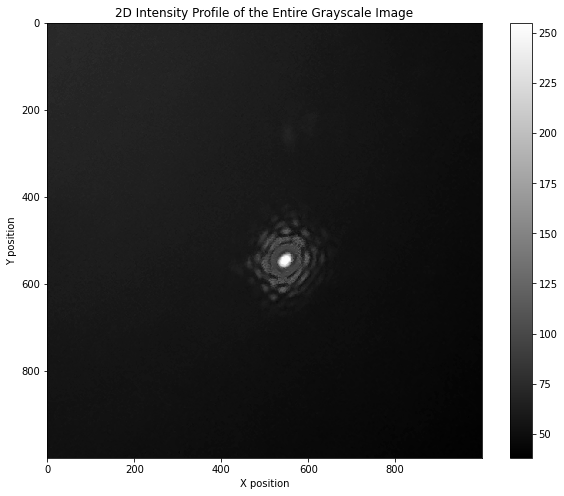

In [4]:
# Visualize the 2D intensity profile using a black and white colormap
plt.figure(figsize=(10, 8))  # Adjust size based on your display preferences
plt.imshow(gray_image, cmap='gray', interpolation='nearest')
plt.colorbar()  # Adds a color bar to help interpret the intensity values
plt.title('2D Intensity Profile of the Entire Grayscale Image')
plt.xlabel('X position')
plt.ylabel('Y position')
plt.show()

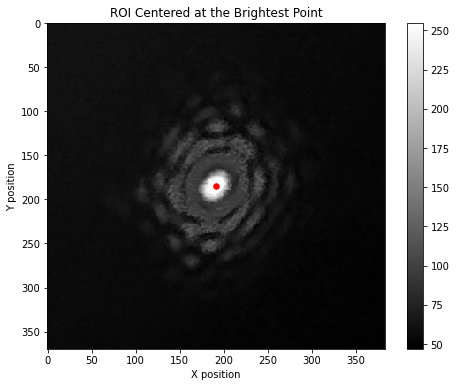

In [5]:
plt.figure(figsize=(8, 6))
plt.imshow(roi, cmap='gray', interpolation='nearest')
plt.colorbar()
plt.scatter(roi_width // 2, roi_height // 2, c='red', s=30)  # Mark the brightest point
plt.title('ROI Centered at the Brightest Point')
plt.xlabel('X position')
plt.ylabel('Y position')
plt.show()

In [6]:
roi = roi - np.min(roi)

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load your image
diffraction_image_path = '../duck_diffraction.jpg'
diffraction_image = cv2.imread(diffraction_image_path)[96:712, 100:720]

# Convert to grayscale
gray_diffraction_image= cv2.cvtColor(diffraction_image, cv2.COLOR_BGR2GRAY)

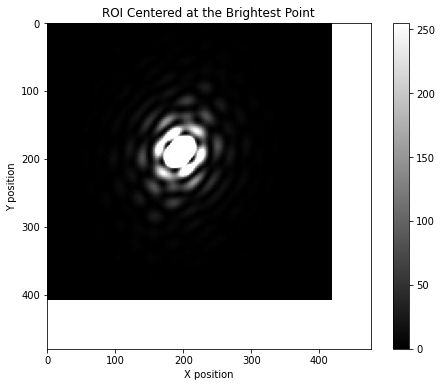

In [8]:
plt.figure(figsize=(8, 6))
plt.imshow(gray_diffraction_image, cmap='gray', interpolation='nearest')
plt.colorbar()
plt.title('ROI Centered at the Brightest Point')
plt.xlabel('X position')
plt.ylabel('Y position')
plt.show()

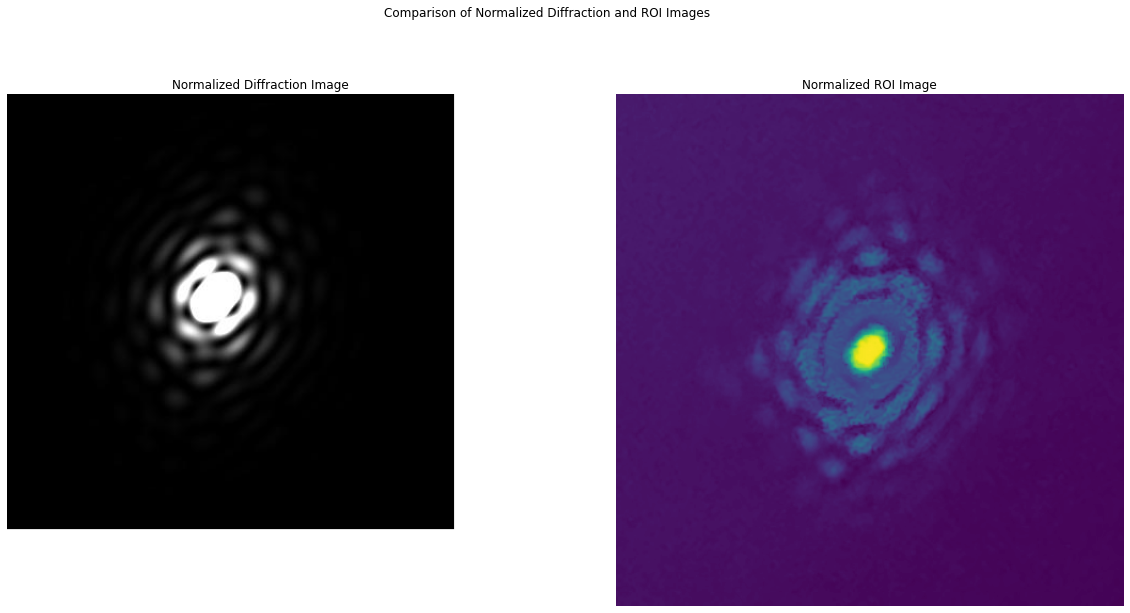

In [9]:
# Check if both images are the same size, if not, resize
if roi.shape != diffraction_image.shape:
    roi = cv2.resize(roi, (diffraction_image.shape[1], diffraction_image.shape[0]))

# Normalize the images for better effect in visualization
diffraction_image_norm = cv2.normalize(diffraction_image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
roi_image_norm = cv2.normalize(roi, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

# Create a figure to display the results with two subplots
plt.figure(figsize=(20, 10))  # Larger figure size to accommodate two subplots

# Plot diffraction_image in one subplot
ax1 = plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
ax1.imshow(diffraction_image_norm)
ax1.set_title('Normalized Diffraction Image')
ax1.axis('off')  # Hide axes for better visualization

# Plot roi_image in another subplot
ax2 = plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
ax2.imshow(roi_image_norm)
ax2.set_title('Normalized ROI Image')
ax2.axis('off')  # Hide axes for better visualization

plt.suptitle('Comparison of Normalized Diffraction and ROI Images')
plt.show()

In [10]:
cv2.imwrite('./Comparison/duck_pattern.png', diffraction_image_norm * 255)  # cv2.imwrite expects [0, 255] for uint8
cv2.imwrite('./Comparison/duck_image.png', roi_image_norm * 255)  # Multiply by 255 if saving normalized images as uint8

True

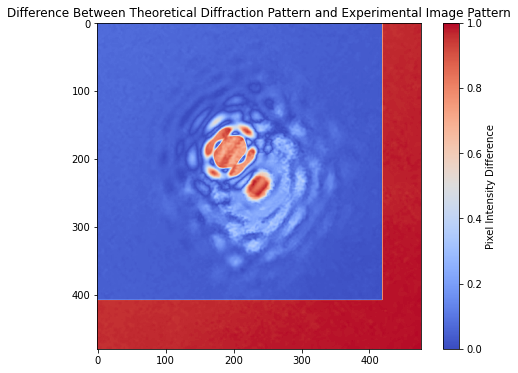

In [11]:
# Calculate the difference image
image_difference = np.abs(diffraction_image_norm[:,:,0] - roi_image_norm)

# Create a figure to display the results
plt.figure(figsize=(8, 6))

# Plot the difference image
plt.imshow(image_difference, cmap='coolwarm')  
plt.colorbar(label='Pixel Intensity Difference')
plt.title('Difference Between Theoretical Diffraction Pattern and Experimental Image Pattern')
plt.show()

In [11]:
from skimage.metrics import structural_similarity as ssim
from scipy.stats import wasserstein_distance

def calculate_mse(img1, img2):
    return np.mean((img1 - img2) ** 2)

def calculate_ssim(img1, img2, data_range):
    return ssim(img1, img2, data_range=data_range)

def calculate_psnr(img1, img2, mse):
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    return 20 * np.log10(max_pixel / np.sqrt(mse))

def calculate_cross_correlation(img1, img2):
    # Flatten the images to 1D arrays
    img1_flat = img1.flatten()
    img2_flat = img2.flatten()
    
    # Subtract the mean
    img1_mean = img1_flat - np.mean(img1_flat)
    img2_mean = img2_flat - np.mean(img2_flat)
    
    # Compute the standard deviations
    std1 = np.std(img1_flat)
    std2 = np.std(img2_flat)
    
    # Check for zero standard deviation to avoid division by zero
    if std1 == 0 or std2 == 0:
        return 0
    
    # Calculate the normalized cross-correlation
    norm_correlation = (np.sum(img1_mean * img2_mean) / (std1 * std2)) / len(img1_flat)
    
    return norm_correlation

def calculate_histogram_comparison(img1, img2):
    hist1 = cv2.calcHist([img1], [0], None, [256], [0, 256])
    hist2 = cv2.calcHist([img2], [0], None, [256], [0, 256])
    return wasserstein_distance(hist1.ravel(), hist2.ravel())

def feature_based_comparison(img1, img2):
    # Convert images to 8-bit grayscale if they are not already
    if img1.dtype != np.uint8:
        img1 = (255 * img1).clip(0, 255).astype(np.uint8)
    if img2.dtype != np.uint8:
        img2 = (255 * img2).clip(0, 255).astype(np.uint8)

    # Convert to grayscale if they are color images
    if len(img1.shape) == 3:
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    if len(img2.shape) == 3:
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    orb = cv2.ORB_create()
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)
    return len(matches)

img1, img2 = roi_image_norm, diffraction_image_norm[:,:,0]
mse_value = calculate_mse(img1, img2)
ssim_value = calculate_ssim(img1, img2, 1.0)
psnr_value = calculate_psnr(img1, img2, mse_value)
cross_corr_value = calculate_cross_correlation(img1, img2)
histogram_comp_value = calculate_histogram_comparison(img1, img2)
feature_count = feature_based_comparison(img1, img2)

print("Mean Squared Error:", mse_value)
print("Structural Similarity Index:", ssim_value)
print("Peak Signal-to-Noise Ratio:", psnr_value)
print("Cross Correlation:", cross_corr_value)
print("Histogram Comparison:", histogram_comp_value)
print("Feature Matches:", feature_count)

Mean Squared Error: 0.04090824
Structural Similarity Index: 0.3284504699688265
Peak Signal-to-Noise Ratio: 62.01269559218893
Cross Correlation: 0.7452136573104315
Histogram Comparison: 138.1953125
Feature Matches: 69
